In [60]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import geopandas as gpd

In [61]:
from sklearn.model_selection import GridSearchCV
from  sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV
from sklearn.utils.validation import check_array
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_squared_error, r2_score  
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve  

from lightgbm import LGBMRegressor

In [62]:
bodyfont = {'fontname':'Helvetica'} # Body font 
titlefont = {'fontname':'Futura'}

# Monthly

In [63]:
london_monthly = pd.read_csv('./data/housing_in_london_monthly_variables.csv')

In [64]:
london_monthly# get rid off the 'no_of_crimes' column, because it has too many missing values
london_monthly.drop('no_of_crimes', axis = 1, inplace = True)   

# Fill the missing values in the 'houses_sold' column with the mean of the area
london_monthly['houses_sold'].fillna(london_monthly.groupby('area')['houses_sold'].transform('mean'), inplace = True)

# Extract the year from the date column
london_monthly['date'] = pd.to_datetime(london_monthly['date'], errors='coerce')
london_monthly['year'] = london_monthly['date'].dt.year

In [65]:
# discard the data from 2020, because the year is not complete
london_monthly = london_monthly[london_monthly['year'] < 2020]

In [66]:
london_boroughs = london_monthly[london_monthly['borough_flag'] == 1]['area'].unique()

In [67]:
# Let's get rid of the non-english regions. 
england_regions = ['east midlands', 'yorks and the humber', 'south west', 'south east', 'east of england', 'west midlands', 'north west', 'north east']
london = london_monthly[london_monthly['area'].isin(london_boroughs)]
england = london_monthly[london_monthly['area'].isin(england_regions)]


In [68]:
# Calculate the average price for each area for each date. 
london_price = london.groupby('date')['average_price'].mean()
england_price = england.groupby('date')['average_price'].mean()

In [70]:
london_price

date
1995-01-01     81906.424242
1995-02-01     81527.969697
1995-03-01     81349.272727
1995-04-01     81432.515152
1995-05-01     82277.303030
                  ...      
2019-08-01    526506.393939
2019-09-01    528443.060606
2019-10-01    525602.666667
2019-11-01    522975.878788
2019-12-01    524032.787879
Name: average_price, Length: 300, dtype: float64

In [69]:
# Set the style for Seaborn plots
sns.set(style='whitegrid')

# Create a Seaborn lineplot to visualize house prices over time
plt.figure(figsize=(10, 5))
sns.lineplot(data=london_price, x='Date', y='London_Price', label='London', color='navy', lw=2)
sns.lineplot(data=england_price, x='Date', y='England_Price', label='England', color='darkorange', lw=2)

# Highlight important events
plt.axvspan('2007-07-01', '2009-06-21', alpha=0.5, color='#E57715')
plt.text(x='2008-05-01', y=390000, s='The GFC', rotation=90, fontsize=12)
plt.axvline(x='2016-06-23', lw=2, color='darkblue', linestyle='--')
plt.text(x='2015-11-01', y=210000, s='Brexit Referendum', rotation=90, fontsize=12)

# Customize plot details
plt.title('Time Evolution of Average House Price', size=14)
plt.ylabel('Average Price', size=12)
plt.xlabel('Date', size=12)
plt.xticks(rotation=45)
plt.legend(fontsize=10, loc='lower right')

# Show the Seaborn plot
plt.show()

TypeError: Data source must be a DataFrame or Mapping, not <class 'pandas.core.series.Series'>.

<Figure size 1000x500 with 0 Axes>

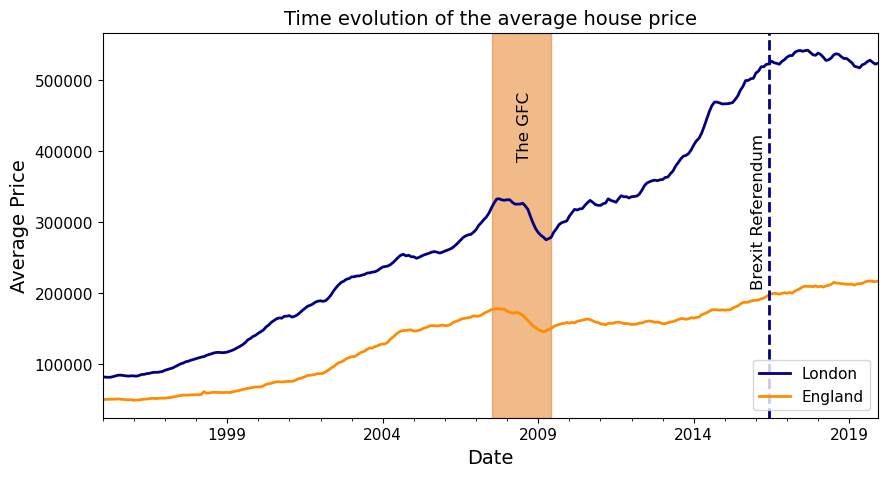

In [11]:
# Plot the time evolution of the average house price in London and England
plt.figure(figsize = (10, 5))
font_size = 14
london_price.plot(y = 'average_price', color = 'navy', lw = 2, label = 'London')
england_price.plot(y = 'average_price', color = 'darkorange', lw = 2, label = 'England')
plt.axvspan('2007-07-01', '2009-06-21', alpha = 0.5, color = '#E57715')
plt.text(x = '2008-05-01', y = 390000, s = 'The GFC', rotation = 90, fontsize = font_size-2)
plt.axvline(x = '2016-06-23', lw = 2, color = 'darkblue', linestyle = '--')
plt.text(x = '2015-11-01', y = 210000, s = 'Brexit Referendum', rotation = 90, fontsize = font_size-2)
plt.title('Time evolution of the average house price', size = font_size)
plt.ylabel('Average Price', size = font_size)
plt.xticks(size = font_size - 3)
plt.xlabel('Date', size = font_size)
plt.yticks(size = font_size - 3)
plt.legend(fontsize = font_size - 3, loc = 'lower right')
#plt.savefig('time_evolution_of_average_house_price.jpg', dpi=300) 

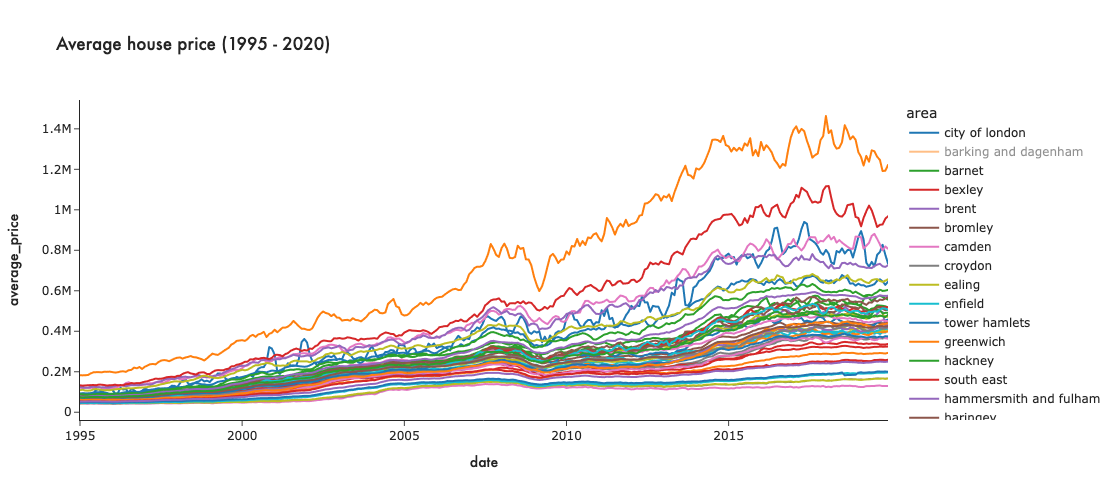

In [63]:
# Also wanted to try some Plotly plots, because they have interactive abilities. Feel free to try them out. 
test = px.line(london_monthly, x="date", y="average_price", color='area', template='simple_white', title='Average house price (1995 - 2020)', width=700, height=500)
test.update_layout(title_font_family='Futura', xaxis=dict(title_font_family='Futura'), yaxis=dict(title_font_family='Futura'))
test.show()
#test.write_json('fig2.json')
# and a boxplot
#fig = px.box(london_monthly, x="average_price", template='simple_white', title='Average house price (1995 - 2020)',width=700, height=500, color='borough_flag')
#fig.update_layout(title_font_family='Futura', xaxis=dict(title_font_family='Futura'), yaxis=dict(title_font_family='Futura'))
#fig.write_json('fig1.json')
#fig.show()

<Axes: ylabel='area'>

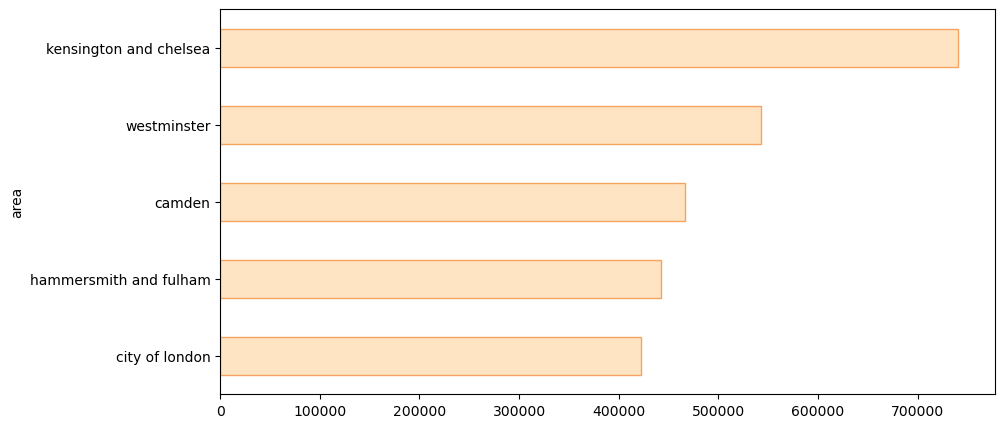

In [69]:
# The average price in each borough fluctuates through time. 
# However, we can calculate its mean which can give us a rough indication of how expensive each area is.

london_borough_prices = london.groupby('area')['average_price'].mean()
london_top5_prices = london_borough_prices.sort_values(ascending = False).to_frame()

# Plot the average price in the 5 most expensive London boroughs
london_top5_prices.head(5).sort_values(by = 'average_price', ascending = True).plot(kind = 'barh', figsize = (10, 5), color = 'bisque', edgecolor = 'sandybrown', legend = False)


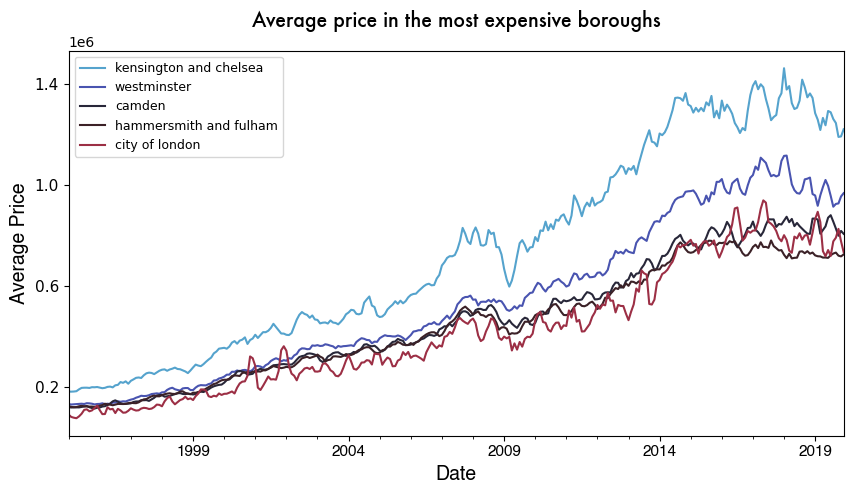

In [71]:
# Plot the average price in the 5 most expensive London boroughs over time
font_size = 14

top5 = london_top5_prices.head().index

colors = sns.color_palette("icefire") # I like this color palette :)
plt.figure(figsize = (10, 5))

for index, i in enumerate(top5):
    df = london[london['area'] == i]
    df = df.groupby('date')['average_price'].mean()
    
    df.plot(y = 'average_price', label = i, color = colors[index])
       
plt.title('Average price in the most expensive boroughs', y = 1.04, size = font_size, **titlefont)
plt.xlabel('Date', size = font_size, **bodyfont)
plt.xticks(size = font_size - 3, **bodyfont)
plt.ylabel('Average Price', size = font_size, **bodyfont)
plt.yticks([0.2*1E+6, 0.6*1E+6, 1.0*1E+6, 1.4*1E+6], size = font_size - 3)
plt.legend(fontsize = font_size - 5);
#plt.savefig('average_price_in_the_most_expensive_boroughs.jpg', dpi=300) 


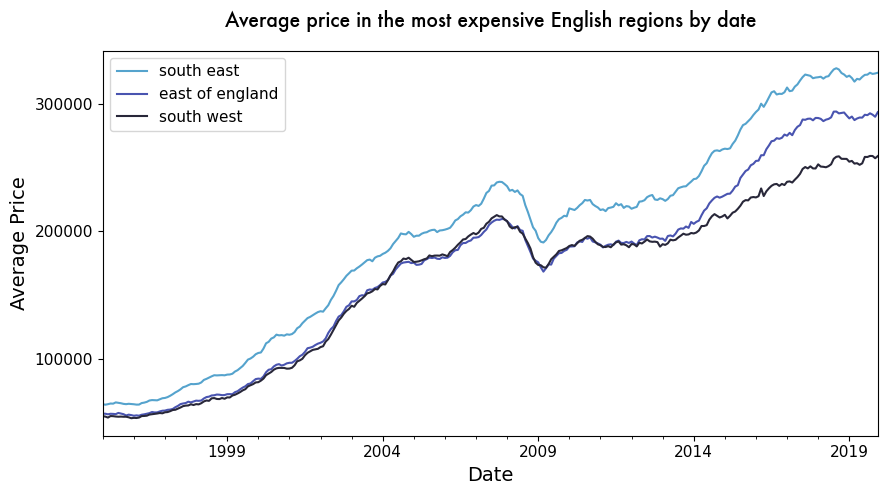

In [18]:
# Let's do the same thing for the most expensive English regions
england_prices = england.groupby('area')['average_price'].mean()
england_top3_prices = england_prices.sort_values(ascending = False).to_frame()
top3 = england_top3_prices.head(3).index
colors = sns.color_palette("icefire")

plt.figure(figsize = (10, 5))
for index, i in enumerate(top3):
    df = england[england['area'] == i]
    df = df.groupby('date')['average_price'].mean()
    df.plot(y = 'average_price', label = i, color = colors[index])

plt.title('Average price in the most expensive English regions by date', size = font_size, y = 1.04, **titlefont)
plt.xlabel('Date', size = font_size)
plt.xticks(size = font_size - 3)
plt.ylabel('Average Price', size = font_size)
plt.yticks([100_000, 200_000, 300_000], size = font_size - 3)
plt.legend(fontsize = font_size - 3);
#plt.savefig('average_price_in_most_expensive_english_regions_by_date.jpg', dpi=300) 

<function matplotlib.pyplot.show(close=None, block=None)>

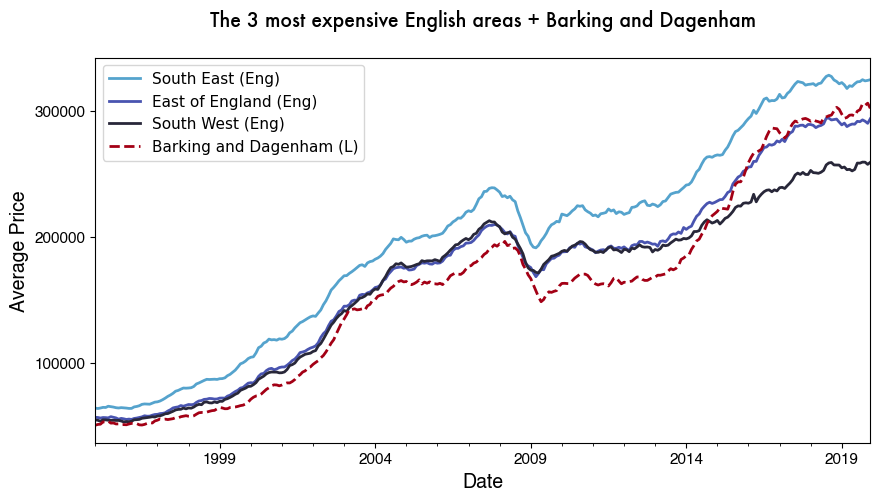

In [19]:
# And now let's compare the cheapest London borough with the most expensive English regions

plt.figure(figsize = (10, 5))
for index, i in enumerate(top3):
    df_ = england[england['area'] == i]
    df_ = df_.groupby('date')['average_price'].mean()
    df_.plot(y = 'average_price', label = i, color = colors[index], lw = 2, linestyle = '-')

london_barking_price = london[london['area'] == 'barking and dagenham'].groupby('date')['average_price'].mean()
london_barking_price.plot(y = 'average_price', lw = 2, linestyle = '--', color = '#A30015', label = 'Barking and Dagenham')

plt.title('The 3 most expensive English areas + Barking and Dagenham', size = font_size, y = 1.06, **titlefont)
plt.xlabel('Date', size = font_size, **bodyfont)
plt.xticks(size = font_size - 3, **bodyfont)
plt.ylabel('Average Price', size = font_size, **bodyfont)
plt.yticks([0.1*1E+6, 0.2*1E+6, 0.3*1E+6], size = font_size - 3, **bodyfont)
plt.legend(labels = ['South East (Eng)', 'East of England (Eng)', 'South West (Eng)', 'Barking and Dagenham (L)'], 
           fontsize = font_size - 3);
#plt.savefig('3_most_expensive_eng+barkinganddagenham.jpg', dpi=300) 
plt.show

([<matplotlib.axis.YTick at 0x170115810>,
 [Text(0, 4000, '4000'),
  Text(0, 8000, '8000'),
  Text(0, 12000, '12000'),
  Text(0, 16000, '16000')])

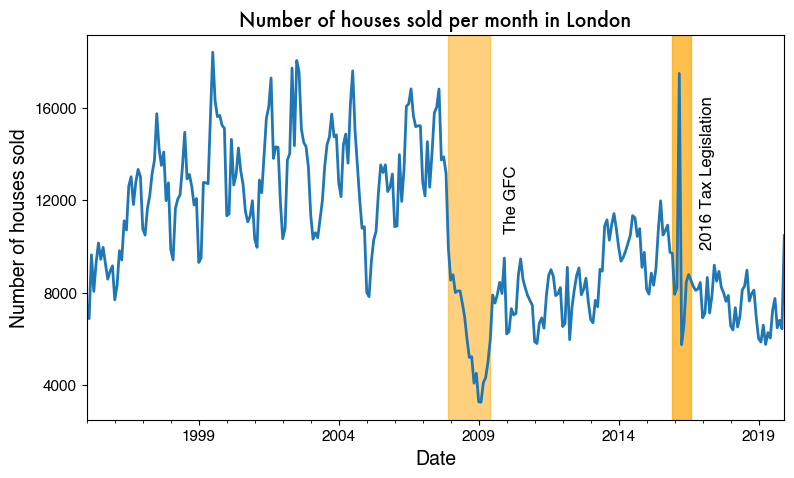

In [73]:
# Let's see how the number of houses sold in London has changed over time 
plt.figure(figsize = (10, 5))
london_houses = london.groupby('date')['houses_sold'].sum()
london_houses.plot(figsize = (9, 5), lw = 2, y = 'houses_sold')
plt.axvspan('2007-12-21', '2009-06-21', alpha = 0.5, color = 'orange')
plt.text(x = '2009-12-01', y = 10700, s = 'The GFC', rotation = 90, fontsize = font_size-2, **bodyfont)
plt.axvspan('2015-12-15', '2016-08-01', alpha = 0.7, color = 'orange')
plt.text(x = '2016-12-01', y = 10000, s = '2016 Tax Legislation ', rotation = 90, fontsize = font_size-2, **bodyfont)
plt.title('Number of houses sold per month in London', size = font_size, **titlefont)
plt.xlabel('Date', size = font_size, **bodyfont)
plt.xticks(size = font_size - 3, **bodyfont)
plt.ylabel('Number of houses sold', size = font_size, **bodyfont)
plt.yticks([4000, 8000, 12000, 16000], size = font_size - 3, **bodyfont)
#plt.savefig('houses_sold_lnd_date.jpg', dpi=300) 

In [89]:
london_borough_houses = london.groupby('area')['houses_sold'].sum()
london_top5_houses = london_borough_houses.sort_values(ascending = False).to_frame()
london_top5_houses.head(5)

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


,houses_sold
area,
wandsworth,164419.063545
bromley,149012.709030
croydon,146393.979933
barnet,134094.983278
lambeth,118347.491639


## London Heatmap

In [71]:
# Read the shapefile data into a GeoDataFrame 
london_map = gpd.read_file('./data/London Map Info/London_Borough_Excluding_MHW.shp')

# Convert the column names to lowercase
london_map.columns = london_map.columns.str.lower()

# Print the first few rows of the GeoDataFrame
print(london_map.head()) 

ImportError: The 'read_file' function requires the 'pyogrio' or 'fiona' package, but neither is installed or imports correctly.
Importing fiona resulted in: dlopen(/Users/charliewright/miniconda3/lib/python3.11/site-packages/fiona/ogrext.cpython-311-darwin.so, 0x0002): Library not loaded: @rpath/libLerc.4.dylib
  Referenced from: /Users/charliewright/miniconda3/lib/libgdal.31.dylib
  Reason: tried: '/Users/charliewright/miniconda3/lib/libLerc.4.dylib' (no such file), '/Users/charliewright/miniconda3/lib/python3.11/site-packages/fiona/../../../libLerc.4.dylib' (no such file), '/Users/charliewright/miniconda3/lib/python3.11/site-packages/fiona/../../../libLerc.4.dylib' (no such file), '/Users/charliewright/miniconda3/bin/../lib/libLerc.4.dylib' (no such file), '/Users/charliewright/miniconda3/bin/../lib/libLerc.4.dylib' (no such file), '/usr/local/lib/libLerc.4.dylib' (no such file), '/usr/lib/libLerc.4.dylib' (no such file)
Importing pyogrio resulted in: No module named 'pyogrio'

## Yearly

In [12]:
london_yearly = pd.read_csv('./data/housing_in_london_yearly_variables.csv', parse_dates = ['date'])
london_yearly = london_yearly[london_yearly['area'].isin(london_boroughs)] # select only London boroughs

london_yearly[~london_yearly['mean_salary'].str.isnumeric()]['mean_salary'].value_counts()

london_yearly['mean_salary'] = london_yearly['mean_salary'].replace(['#'], np.NaN)
london_yearly['mean_salary'] = london_yearly['mean_salary'].astype(float)

london_yearly['date'] = pd.to_datetime(london_yearly['date'])
london_yearly['year'] = london_yearly['date'].dt.year

In [41]:
#london_monthly_grouped = london.groupby(['area', 'year']).mean().reset_index()  # group based on area and year (take mean)
#london_monthly_grouped = london_monthly_grouped[london_monthly_grouped['year'] >= 1999]            # select all years after 1999 (included)

#london_yearly_group = london_yearly.groupby(['area', 'year']).mean().reset_index() # group it based on area and year

#london_total = pd.merge(london_yearly_group, london_monthly_grouped, on = ['area', 'year'], how = 'left')
#london_total.drop(['borough_flag_x', 'borough_flag_y'], axis = 1, inplace = True)

In [13]:
corr_monthly = london.corr()
corr_table['average_price'].sort_values(ascending=False)

ValueError: could not convert string to float: 'city of london'

# ML Modelling 

In [15]:
def preparing_data_for_ML(df = london_monthly, training_size = 0.75):
  # Drop unneccessary features, in this case 'borough_flag' and 'code' and 'houses_sold'. 
  # 'borough_flag' is a flag that indicates whether the area is a London borough or not.
  # 'code' is the code of the area.
  # 'houses_sold' is the number of houses sold in the area.
  prepared_df = df.drop(columns =['houses_sold','borough_flag', 'code'])

  # Extract date feature
  prepared_df['year'] = prepared_df['date'].apply(lambda x: x.year)
  prepared_df['month'] = prepared_df['date'].apply(lambda x: x.month)
  prepared_df = prepared_df.drop(columns =['date'])

  # One-hot encoding for area 
  hot_one = pd.get_dummies(prepared_df['area'], drop_first= True)
  prepared_df = pd.concat([prepared_df, hot_one], axis =1)
  prepared_df = prepared_df.drop(columns =['area'], axis =1)
 

  # Given x, y 
  x = prepared_df.drop(columns = ['average_price'])
  y = prepared_df['average_price']


  # Train-test split (train data 75%, test data 25%)
  x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=training_size, shuffle=True, random_state=42)

  # Standard scaling x
  scaler = StandardScaler()
  scaler.fit(x_train)
  x_train = pd.DataFrame(scaler.transform(x_train), index=x_train.index, columns=x_train.columns)
  x_test = pd.DataFrame(scaler.transform(x_test), index=x_test.index, columns=x_test.columns)

  return x_train, x_test, y_train, y_test


In [16]:
# Use the 'preparing_data_for_ML' function to return x_train, x_test, y_train, y_test 
x_train, x_test, y_train, y_test = preparing_data_for_ML()


In [20]:
london_monthly_test = london_monthly.drop(columns=['houses_sold','borough_flag', 'code'])
london_monthly_test['year'] = london_monthly_test['date'].apply(lambda x: x.year)
london_monthly_test['month'] = london_monthly_test['date'].apply(lambda x: x.month)
london_monthly_test = london_monthly_test.drop(columns =['date'])

In [33]:
# One-hot encoding for area 
hot_one = pd.get_dummies(london_monthly_test['area'], drop_first= True)
london_monthly_test = pd.concat([london_monthly_test, hot_one], axis =1)
london_monthly_test = london_monthly_test.drop(columns =['area'], axis =1)
london_monthly_test

,average_price,year,month,barnet,bexley,brent,bromley,camden,city of london,croydon,...,south east,south west,southwark,sutton,tower hamlets,waltham forest,wandsworth,west midlands,westminster,yorks and the humber
0,91449,1995,1,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,82203,1995,2,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,79121,1995,3,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,77101,1995,4,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,84409,1995,5,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13543,249432,2019,8,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
13544,249942,2019,9,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
13545,249376,2019,10,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
13546,248515,2019,11,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [34]:
x = london_monthly_test.drop(columns = ['average_price'])
y = london_monthly_test['average_price']

In [35]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.75, shuffle=True, random_state=42)


In [37]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train = pd.DataFrame(scaler.transform(x_train), index=x_train.index, columns=x_train.columns)
x_test = pd.DataFrame(scaler.transform(x_test), index=x_test.index, columns=x_test.columns)

In [17]:
london_monthly['month'] = london_monthly['date'].apply(lambda x: x.month)

## KNN

In [39]:
# KNN is a non-parametric method used for classification and regression.
knn = KNeighborsRegressor()
parameters = {'n_neighbors' : [2, 4, 6, 8], 
               'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'] ,
               }

grid_knn = GridSearchCV(estimator= knn, param_grid = parameters, cv = 3, n_jobs=-1)
grid_knn.fit(x_train, y_train)

# Print the best hyperparameters:
print("\n =========== (1) ==========" )
print("\n Results from Grid Search for KNN " )
print("\n The best estimator across ALL searched params:\n",grid_knn.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_knn.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_knn.best_params_)




 =========== (1) ==========

 Results from Grid Search for KNN 

 The best estimator across ALL searched params:
 KNeighborsRegressor(algorithm='kd_tree', n_neighbors=4)

 The best score across ALL searched params:
 0.9881247090113443

 The best parameters across ALL searched params:
 {'algorithm': 'kd_tree', 'n_neighbors': 4}


In [40]:
# Fitting with parameters
knn_ft = grid_knn.best_estimator_
knn_ft.fit(x_train, y_train)

# Printing the results
predictions = knn_ft.predict(x_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

MSE: 336715204.2706235
RMSE: 18349.801205207197
R2: 0.9901325994213922


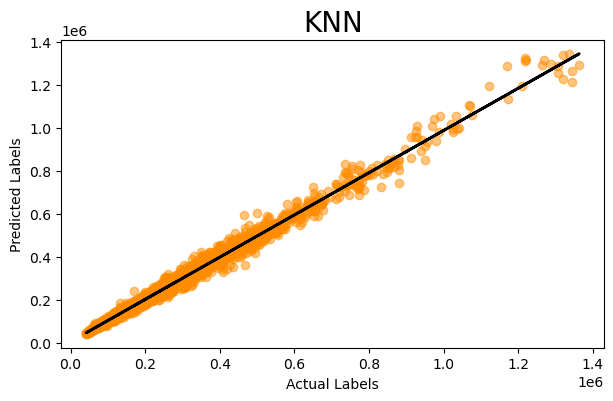

In [43]:
# Plot predicted vs actual
plt.figure(figsize=(7, 4)) 
plt.scatter(y_test, predictions, color='darkorange', alpha=0.5)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('KNN', fontsize= 20)
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='black', linewidth=2, label='Regression Line')
#plt.savefig('knn.jpg', dpi=300) 
plt.show()

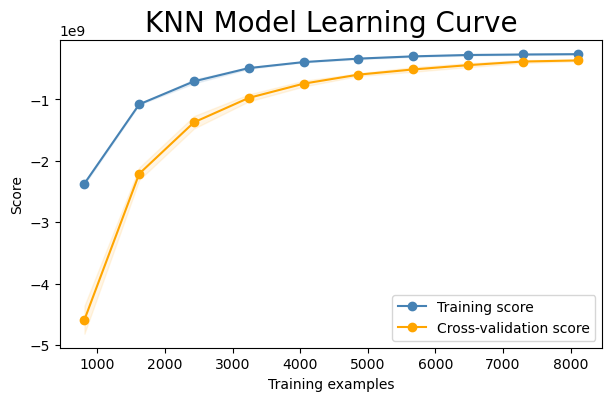

In [44]:
# Plot KNN learning curve
# I use the sklearn learning curve function to plot the learning curve: 
train_sizes, train_scores, test_scores = learning_curve(
    estimator=knn_ft, X=x_train, y=y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='neg_mean_squared_error')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(7, 4))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="steelblue")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="orange")
plt.plot(train_sizes, train_scores_mean, 'o-', color="steelblue", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="orange", label="Cross-validation score")
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('KNN Model Learning Curve', fontsize=20)
plt.legend(loc="best")
#plt.savefig('knn_learning.jpg', dpi=300) 
plt.show()


## Gradient Boosting Machine

In [20]:
## LightGBM
# LightGBM is a gradient boosting framework that uses tree based learning algorithms.
lgbm = LGBMRegressor()
parameters = {'boosting_type' : ['gbdt', "dart", 'goss'],
               'learning_rate': [0.01, 0.03, 0.1] ,
               'n_estimators' : [100, 500, 1000] }

grid_lgbm = GridSearchCV(estimator=lgbm, param_grid = parameters, cv = 3, n_jobs=-1)
grid_lgbm.fit(x_train, y_train)

# Print the best hyperparameters:
print("\n =========== (2) ==========" )
print("\n Results from Grid Search for LGBM " )
print("\n The best estimator across ALL searched params:\n",grid_lgbm.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_lgbm.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_lgbm.best_params_)

KeyboardInterrupt: 

In [ ]:
lgbm_ft = grid_lgbm.best_estimator_
lgbm_ft.fit(x_train, y_train)

# Printing the results
predictions = lgbm_ft.predict(x_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

In [ ]:
# Plot predicted vs actual
plt.figure(figsize=(7, 4)) 
plt.scatter(y_test, predictions, color = 'darkorange', alpha=0.5)
plt.xlabel('Actual Labels', **bodyfont)
plt.ylabel('Predicted Labels', **bodyfont)
plt.title('LGBM', fontsize= 20, **titlefont)

# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='navy', linewidth=2, label='Regression Line')
plt.savefig('lgbm.jpg', dpi=300) 
plt.show()

In [ ]:
## Plot LGBM learning curve
# I use the sklearn learning curve function to plot the learning curve:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=lgbm_ft, X=x_train, y=y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='neg_mean_squared_error')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Creating the plot | learning curve
plt.figure(figsize=(7, 4))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="steelblue")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="orange")
plt.plot(train_sizes, train_scores_mean, 'o-', color="steelblue", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="orange", label="Cross-validation score")
plt.xlabel('Training examples', **bodyfont)
plt.ylabel('Score', **bodyfont)
plt.title('LGBM Learning Curve', fontsize=20, **titlefont)
plt.legend(loc="best")
plt.savefig('lgbm_learning.jpg', dpi=300) 
plt.show()

## Random Forest

In [104]:
## Random Forest
# Random Forest is an algorithm that is build on multiple decision trees. It can be used both for classification and regression problems.

rfm = RandomForestRegressor()
parameters = {    'n_estimators' : [None, 100 , 300, 1000], 
                  'max_depth'    : [2, 4, 6, None]
                 }

grid_rfm = GridSearchCV(estimator=rfm, param_grid = parameters, cv = 3, n_jobs=-1)
grid_rfm.fit(x_train, y_train)

# Print the best hyperparameters:
print("\n =========== (3) ==========" )
print("\n Results from Grid Search for RandomForest " )
print("\n The best estimator across ALL searched params:\n",grid_rfm.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_rfm.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_rfm.best_params_)


/Users/charliewright/miniconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning:


12 fits failed out of a total of 48.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/charliewright/miniconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charliewright/miniconda3/lib/python3.11/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Users/charliewright/miniconda3/lib/python3.11/site-packages/sklearn/base.py", line 638, in _validate_params
    validate_p


 =========== (3) ==========

 Results from Grid Search for RandomForest 

 The best estimator across ALL searched params:
 RandomForestRegressor(n_estimators=1000)

 The best score across ALL searched params:
 0.9954807089413845

 The best parameters across ALL searched params:
 {'max_depth': None, 'n_estimators': 1000}


In [26]:
# Fit the model with the best hyperparameters
rfm_ft = grid_rfm.best_estimator_
rfm_ft.fit(x_train, y_train)

# Printing the results
predictions = rfm_ft.predict(x_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

MSE: 93972790.15800202
RMSE: 9693.956372813012
R2: 0.9972461381243919


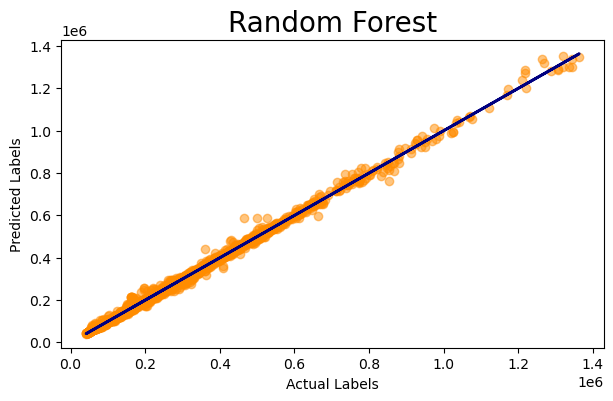

In [28]:
# Plot predicted vs actual
plt.figure(figsize=(7, 4)) 
plt.scatter(y_test, predictions, color = 'darkorange', alpha=0.5)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Random Forest', fontsize= 20)
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='navy', linewidth=2, label='Regression Line')
#plt.savefig('random_forest.jpg', dpi=300) 
plt.show()

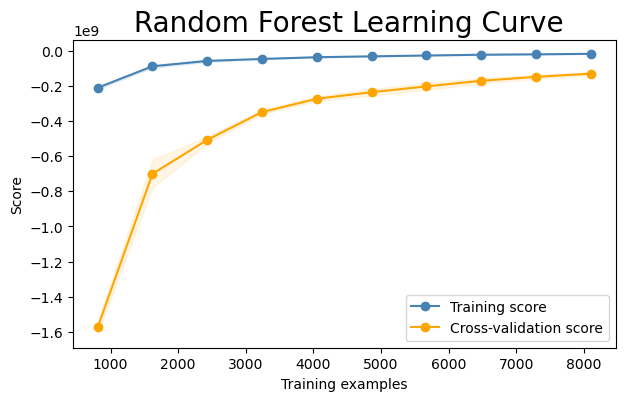

In [30]:
## Plot Random Forest learning curve
# Same here as above, I use the sklearn learning curve function to plot the learning curve: 
train_sizes, train_scores, test_scores = learning_curve(
    estimator=rfm_ft, X=x_train, y=y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='neg_mean_squared_error')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


# Creating the plot | learning curve 
plt.figure(figsize=(7, 4))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="steelblue")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="orange")
plt.plot(train_sizes, train_scores_mean, 'o-', color="steelblue", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="orange", label="Cross-validation score")
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title(' Random Forest Learning Curve', fontsize=20)
plt.legend(loc="best")
#plt.savefig('random_forest_learning.jpg', dpi=300) 
plt.show()
